# Object-Oriented Image Processing

**Author:** [Tony Kabilan Okeke](mailto:tko35@drexel.edu)

In this notebook, we will look at image-segmentation approaches for analyzing
cellular microscopy images. We will use the [scikit-image](https://scikit-image.org/)
and [SimpleITK](https://simpleitk.org/) libraries to perform image processing
tasks.

## Set-Up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
# Import the bmes package
import sys, os
sys.path.append(os.environ['BMESAHMETDIR'])
import bmes

# Install necessary packages
bmes.pipinstall('skimage','scikit-image')
bmes.pipinstall('SimpleITK')

# Import necessary packages
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import skimage
from skimage import io, color, filters, measure, morphology
from scipy import ndimage

In [3]:
# Custom functions
def imshow(img: np.ndarray, title: str='', dbg: bool=True, **imkwargs) -> None:
    """
    Show an image with a title
    """

    if dbg:
        io.imshow(img, **imkwargs)
        if title: plt.title(title)
        io.show();

In [4]:
# Download sample images
URLS = [
    (('http://sacan.biomed.drexel.edu/lib/exe/fetch.php?media=course:bcomp2:'
     'img:samplecells.jpg'), 'img/samplecells.jpg'),
]
files = [bmes.downloadurl(url, path) for url, path in URLS]

## `scikit-image` Demo

### Loading and viewing images

- When images are loaded with `io.imread`, a NumPy array with shape `(M, N, C)`
  is returned, where `M` and `N` are the image dimensions and `C` is the number
  of channels.
  - For RGB images, there will be 3 channels.
  - For grayscale images, there will be 1 channel.
- Image coordinates are flipped in the NumPy array, so the first index is the
  vertical axis and the second index is the horizontal axis.

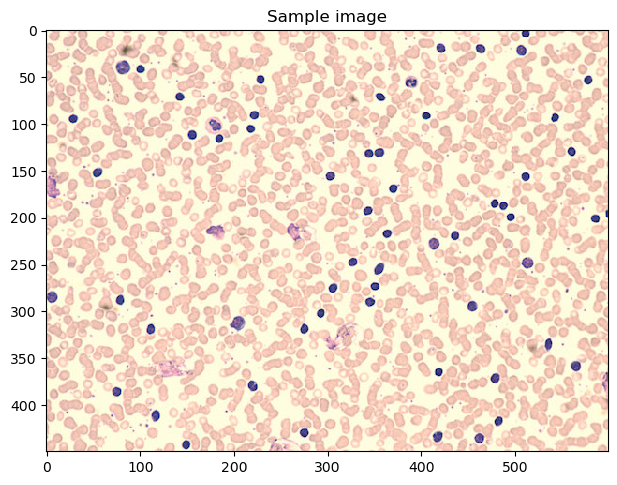

Image: 450 rows, 600 cols, 3 channels


In [5]:
# Load a sample image
img= io.imread(files[0])
imshow(img, 'Sample image')

# Let's look at the image dimensions
nrow, ncol, nchan = img.shape
print('Image: {} rows, {} cols, {} channels'.format(nrow, ncol, nchan))

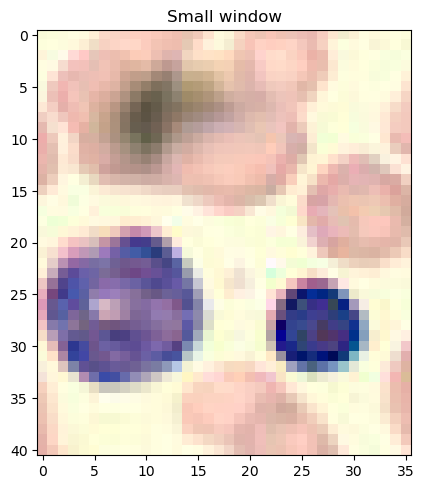

Image: 41 rows, 36 cols, 3 channels


In [6]:
# We can extract a small window from the top left corner of the image
I = img[14:55, 74:110, :].copy()
imshow(I, 'Small window');

# Let's look at the image dimensions
nrow, ncol, nchan = I.shape
print('Image: {} rows, {} cols, {} channels'.format(nrow, ncol, nchan))

## Image Segmentation

- When working with microscopy images, the goal of segmentation is typically to
  identify the boundaries of cells.
- This allows us to measure the size and shape of cells, as well as the
  intensity of the image within the cells.
  - The simplest task would be to count the number of cells in an image.

### Color-based segmentation

- One way of extracting cells from an image is to use color-based segmentation.
- If the cells of interest are of similar colors, we can use a color threshold
  to extract the cells.
- Below, we will use a color threshold to extract the cells from the image.
  - The background appears to have the color `rgb(250, 250, 220)`
  - We will compare the mean absolute difference between the background color
    and the color of each pixel in the image.
  - If the difference is less than a threshold, we will set the pixel to white.

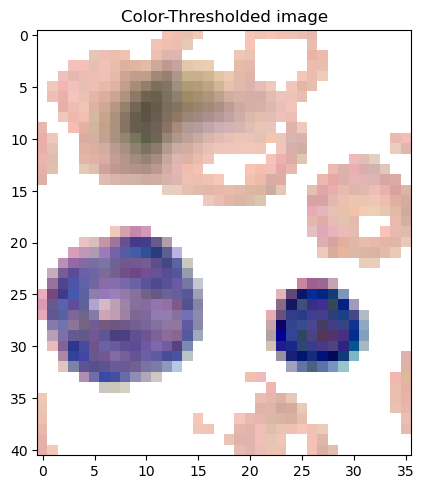

In [7]:
cell_color = np.array([250, 250, 220])
threshold = 30

for i in range(nrow):
    for j in range(ncol):
        if (abs(I[i,j,:] - cell_color)).mean() < threshold:
            I[i,j,:] = 255
imshow(I, 'Color-Thresholded image');

### Edge-based segmentation

- Another way of extracting cells from an image is to use edge-based
  segmentation.
- This typically involves the following steps:
  - *Grayscale conversion* (for color images)
  - *Edge detection*
  - *Dlilation* and *Gap-Filling* (to fill in gaps)
  - *Identifying connected components* (to identify individual cells)

#### Grayscale conversion
- Most imge processing algorithms are designed for single-channel images.
- Thus, we need to convert the images to grayscale - such that each pixel
  has a single intensity value.
- One way of doing this is to take the mean of the RGB values. 
- This is implemented in `color.rgb2gray`.

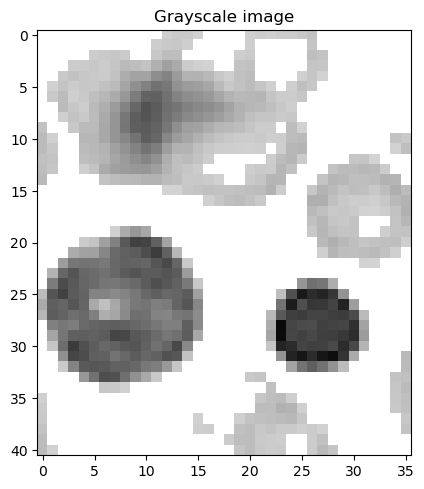

In [8]:
# Convert to grayscale
G = skimage.color.rgb2gray(I)
imshow(G, 'Grayscale image', cmap='gray');

#### Edge detection

- Edge detection is the process of identifying the boundaries of objects in an
  image.
- This is typically done by convolving the image with a kernel that highlights
  the edges.
- There are several algorithms for edge detection, including:
  - [Sobel](https://en.wikipedia.org/wiki/Sobel_operator)
  - [Canny](https://en.wikipedia.org/wiki/Canny_edge_detector)
  - [Roberts](https://en.wikipedia.org/wiki/Roberts_cross)
  - [Prewitt](https://en.wikipedia.org/wiki/Prewitt_operator)
- Below, we will implement the Sobel algorithm.
  - This involves convolving the image with a kernel in the horizontal and
    vertical directions.
  - Each pixel will be compared to neighboring pixels in the horizontal and
    vertical directions.
  - The sobel operator is calculated by taking the difference (dx and dy) and
    adding the absolute values.
  - The result is a new image that highlights the edges in the original image.

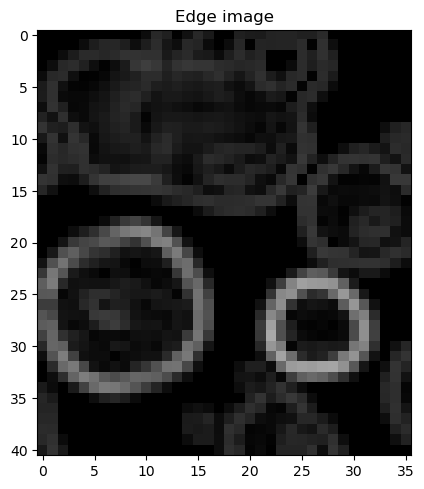

In [9]:
E = filters.sobel(G)
imshow(E, 'Edge image');

#### Dilation

*Morphological dilation* sets the value of a pixel to the maximum over all
pixel values within a local neighborhood centered about it. The results are
dependent of the shape of the neighborhood. The neighborhood is typically
chosen to be a disk or a square.

Dilation is typically used to connect edges that are close together. This is
done by setting the value of the center pixel to the maximum value of the
pixels in the neighborhood. This will connect edges that are close together.

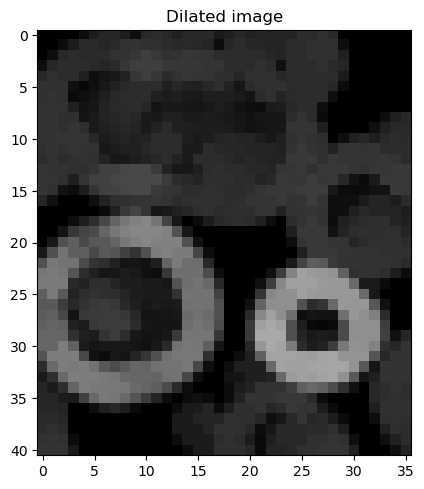

In [10]:
# Using a diamond structuring element
nhood = morphology.diamond(1)
D = morphology.dilation(E, nhood)
imshow(D, 'Dilated image');

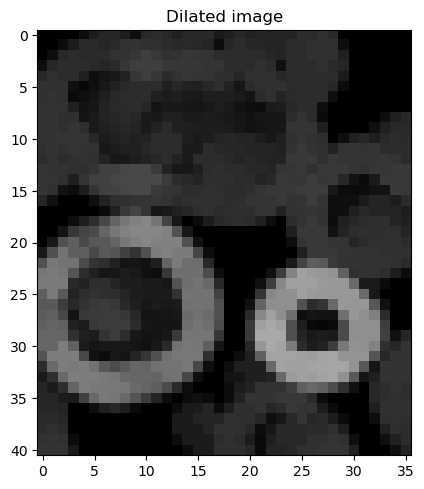

In [11]:
# Using a disk structuring element
nhood = morphology.disk(1)
D = morphology.dilation(E, nhood)
imshow(D, 'Dilated image');

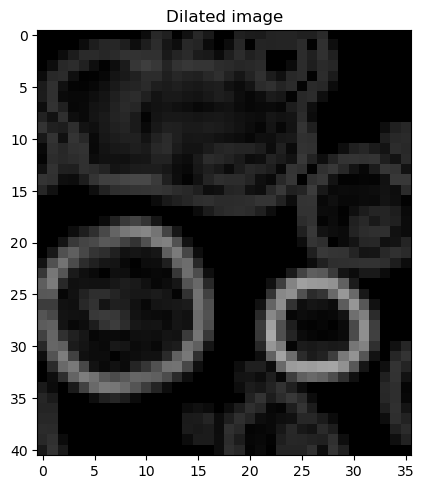

In [12]:
# Using a square structuring element
nhood = morphology.square(1)
D = morphology.dilation(E, nhood)
imshow(D, 'Dilated image');

#### Gap-Filling

We will use morphologica reconstruction to fill in gaps in the image. `seed` and
`mask` represent the maximum and minimum possible values of the reconstructed
image, respectively. `seed` is set to the maximum value in the image, except for
along its borders, the original values are preserved. `mask` is set to the
edge-detected image.  
*Erosion* begins from the borders in the `seed` and stops when it reaches the
`mask`. The result is a new image that fills in the gaps in the edge-detected
image.

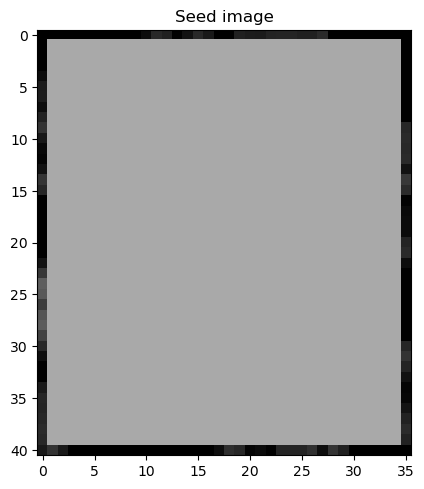

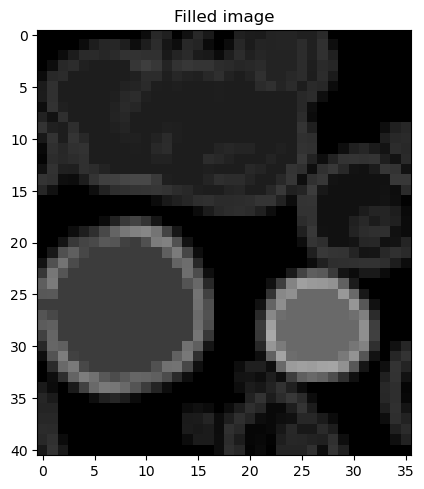

In [13]:
# Fill in gaps in the dilated image

## Define a seed
seed = D.copy()
seed[1:-1, 1:-1] = D.max()
imshow(seed, 'Seed image');

## Define a mask
mask = D.copy()

## Fill in gaps
F = morphology.reconstruction(seed, mask, method='erosion')
imshow(F, 'Filled image');

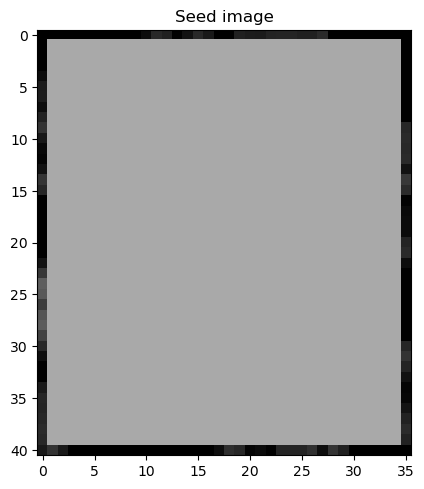

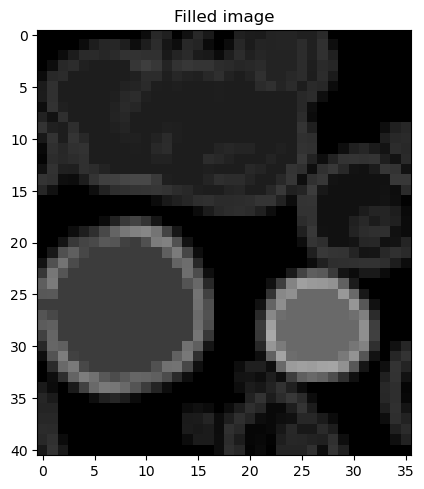

In [14]:
# Fill in gaps in the edge image

## Define a seed
seed = E.copy()
seed[1:-1, 1:-1] = E.max()
imshow(seed, 'Seed image');

## Define a mask
mask = E.copy()

## Fill in gaps
F = morphology.reconstruction(seed, mask, method='erosion')
imshow(F, 'Filled image');

The dilation and erosion steps above can also be done in a single step using
`morphology.closing`.

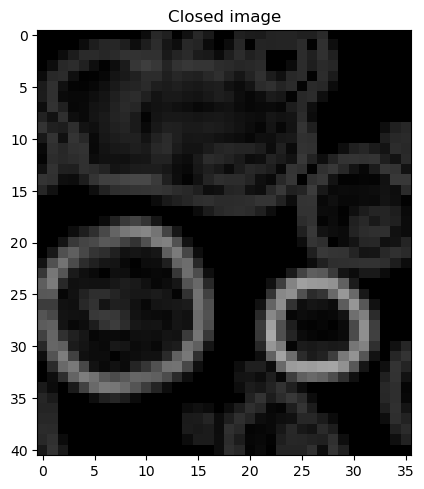

In [15]:
# Use closing to fill in gaps
C = morphology.closing(E, nhood)
imshow(C, 'Closed image');

#### Smoothing

Morphological erosion sets a pixel at $(i, j)$ to the minimum over all pixels in
the neighborhood centered at $(i, j)$. The neighborhood is typically chosen to
be a disk or a square. Erosion shrinks bright regions and enlarges dark regions.

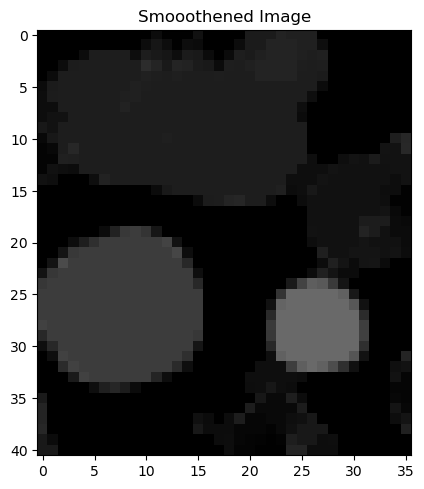

In [16]:
# Using the filled image above
S = morphology.erosion(F, morphology.diamond(1))
imshow(S, 'Smooothened Image');

#### Connected Components

- Connected components are groups of pixels that are connected to each other.
- We can use connected components to identify individual cells in an image.
- We'll use the `scipy.ndimage` module to identify the connected components
  - The `ndimage.label` function returns a tuple of two arrays.
    - The first array is the labeled image, where each connected component is
      assigned a unique integer.
    - The second array is the number of connected components in the image.
  - It requires a binary image as input, so we will use a threshold to convert
    the grayscale image to a binary image.

/home/kabil/.anaconda3/envs/bmes550/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


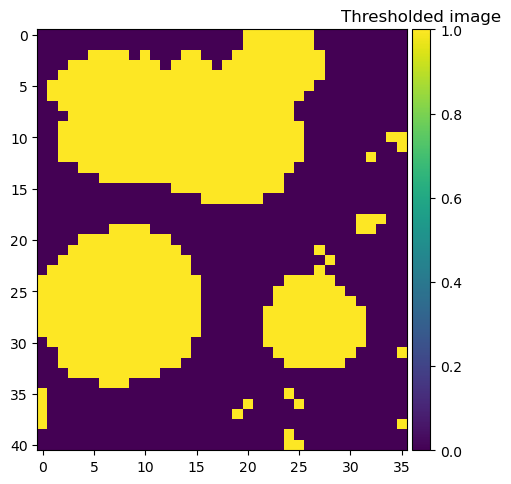

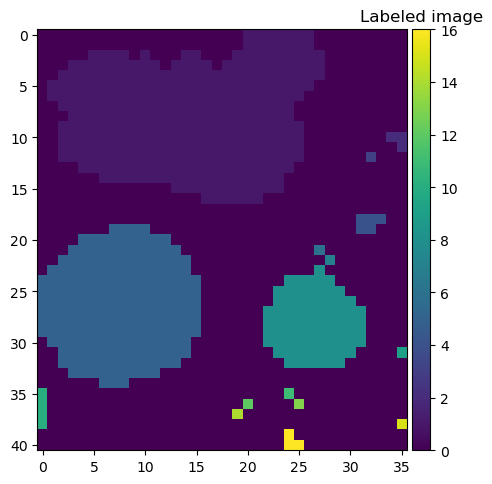

Number of cells: 16


In [122]:
# Threshold the image
T = (S > 0.1).astype(np.uint8)
imshow(T, 'Thresholded image');

# Label the image
L, n = ndimage.label(T)
imshow(L, 'Labeled image');
print('Number of cells: {}'.format(n))

min area: 1, max area: 327


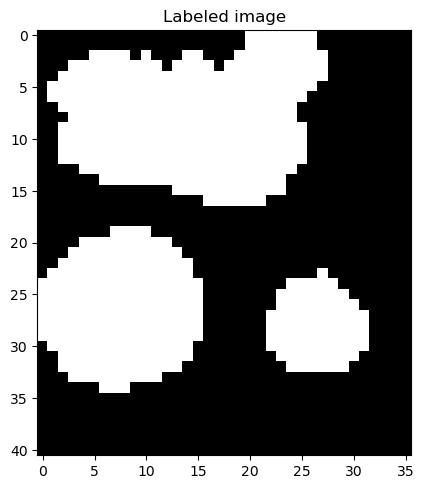

Number of cells: 3


In [132]:
# Remove small objects
blobs = measure.regionprops(L)
areas = [blob.area for blob in blobs]
print('min area: {}, max area: {}'.format(min(areas), max(areas)))

# Remove small objects (skimage)
L2 = morphology.remove_small_objects(L, min_size=20)
L2 = np.where(L2 > 0, 255, 0).astype(np.uint8)
imshow(L2, 'Labeled image');

# Remove small objects (scipy)
filtblobs = [blob for blob in blobs if blob.area > 20]
print('Number of cells: {}'.format(len(filtblobs)))

#### Overlaying Results

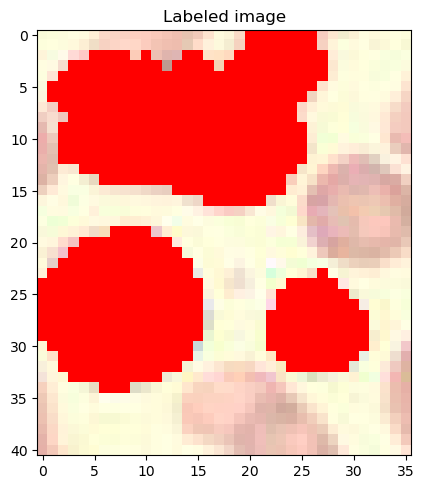

In [139]:
# Copy the original image
O = img[14:55, 74:110, :].copy()
O[L2 == 255, :] = [255, 0, 0]

# Draw the bounding boxes (skimage)
# O[L2] = 
# for i, blob in enumerate(filtblobs):
#     # Determine bounding box
#     minr, minc, maxr, maxc = blob.bbox

#     # Duplicate the grayscale blob into 3 channels
#     blob_color = np.repeat(blob.image[:,:,np.newaxis], 3, axis=2)

#     # Set the color for pixels outside the cell
#     cells = np.where(blob_color, blob_color, O[minr:maxr, minc:maxc, :])

#     # Color the cells in red
#     cells[:,:,0][blob.image] = 255
#     cells[:,:,1][blob.image] = 0

#     # Overlay the cells on the original image
#     O[minr:maxr, minc:maxc, :] = cells

imshow(O, 'Labeled image');

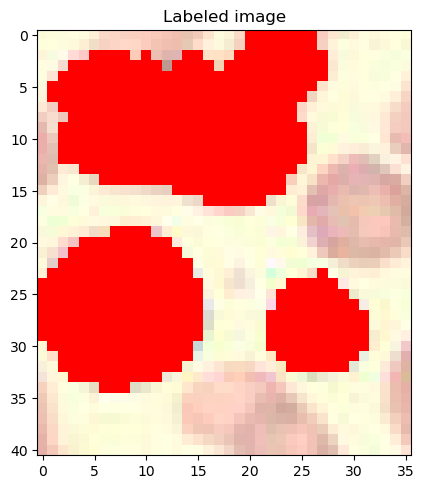

In [119]:
# Copy the original image
O = img[14:55, 74:110, :].copy()

# Draw the bounding boxes (scipy)
for i, blob in enumerate(filtblobs):
    # Determine bounding box
    minr, minc, maxr, maxc = blob.bbox

    # Duplicate the grayscale blob into 3 channels
    blob_color = np.repeat(blob.image[:,:,np.newaxis], 3, axis=2)

    # Set the color for pixels outside the cell
    cells = np.where(blob_color, blob_color, O[minr:maxr, minc:maxc, :])

    # Color the cells in red
    cells[:,:,0][blob.image] = 255
    cells[:,:,1][blob.image] = 0

    # Overlay the cells on the original image
    O[minr:maxr, minc:maxc, :] = cells

imshow(O, 'Labeled image');

## Homework

The goal of the assignment is to segment out cells from the sample image and
return the number of cells in the image.

### Templates

- *If you are working in MATLAB:* Download the [template function file](https://sacan.biomed.drexel.edu/lib/exe/fetch.php?rev=&media=course:bcomp2:img:hwbmeimg_countcells.m) and the [template demo file](https://sacan.biomed.drexel.edu/lib/exe/fetch.php?rev=&media=course:bcomp2:img:hwbmeimg_countcells_demo.mlx), and fill in with your code to accomplish the tasks below.

- *If you are working in Python:* Download the [template function file](https://sacan.biomed.drexel.edu/lib/exe/fetch.php?rev=&media=course:bcomp2:img:hwbmeimg_countcells.py) and the [template demo file](https://sacan.biomed.drexel.edu/lib/exe/fetch.php?rev=&media=course:bcomp2:img:hwbmeimg_countcells_demo.ipynb), and fill in with your code to accomplish the tasks below.


### Tasks

- Write a function `numcells = bmeimg_countcells(file, dbg)` that takes in a cell
  microscopy image file name and returns the number of cells in that image. The
  second argument `dbg` is a logical value controlling whether your function
  should display any intermediate images. Your function should perform the
  following steps:
  - If an option to an image processing step is not specified here, you can come
    up with your own options.
  - Use sections/cells (using '%%') in MATLAB for each of the tasks below.
  - If file argument is not given or is empty, use: `file=bmes.downloadurl('http://sacan.biomed.drexel.edu/lib/exe/fetch.php?media=course:bcomp2:img:samplecells.jpg','samplecells.jpg',true)`
  - If `dbg` argument is not give, use `dbg=True`
  - Read the image data from the file (`imread`)
    - If dbg is on, show the image
  - Apply sobel edge detection (`edge`)
    - If dbg is on, show the edges as a binary image
  - Dilate the edge image (`imdilate`)
    - If dbg is on, show the dilated edge image
  - Fill interior gaps of the edge image (`imfill`)
    - If dbg is on, show the filled edge image
  - Smoothen the objects in the edge image (`imerode`)
    - If dbg is on, show the smoothened edge image
  - If dbg is on, show the edge image overlayed on the original image
  - Find the connected components in the edge image (`bwconncomp`)
  - Return the number of cells found

- Choose a parameter used in one of the image processing steps used in
  `bmeimg_countcells()`. Extend the function `bmeimg_countcells()` to take an
  additional input argument for this parameter. In the function use a default
  value when the parameter is not given as input.
  - Analyze the dependency of the cell count found on this parameter, by calling
    `bmeimg_countcells()` for a range of values for this parameter. Create a
    plor for the parameter value vs. the number of cells found.
  - Publish your template demo file as a PDF file.